<a href="https://colab.research.google.com/github/iamshanevictor/CXRaide2.0-Model_Training/blob/main/ITERATION_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Install required libraries
!pip install torchmetrics

import torch
import torchmetrics
from torchvision.models.detection import ssd300_vgg16
from torchvision.ops import nms
from torch.utils.data import Dataset, DataLoader
import os
from torchvision import transforms
from PIL import Image
import pandas as pd
from torch import optim
from tqdm import tqdm
from collections import defaultdict
from torchmetrics.detection import MeanAveragePrecision
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.nn import functional as F

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Dataset class (unchanged)
class CustomDataset(Dataset):
    def __init__(self, root, bbox_csv, multi_label_csv, transform=None):
        self.root = root
        self.bbox_annotations = pd.read_csv(bbox_csv)
        self.multi_label_annotations = pd.read_csv(multi_label_csv)
        self.transform = transform

    def __len__(self):
        return len(self.bbox_annotations)

    def __getitem__(self, idx):
        try:
            img_name = os.path.join(self.root, 'JPEGImages', self.bbox_annotations.iloc[idx, 0] + '.png')
            image = Image.open(img_name).convert("RGB")
            bbox = self.bbox_annotations.iloc[idx, 2:6].values.astype('float').reshape(-1, 4)
            class_name = self.bbox_annotations.iloc[idx, 1]

            multi_labels = self.multi_label_annotations[self.multi_label_annotations['image_id'] == self.bbox_annotations.iloc[idx, 0]].iloc[:, 1:].values.astype('int')[0]

            if len(bbox) == 0:
                bbox = torch.zeros((0, 4), dtype=torch.float32)
                labels = torch.zeros((0,), dtype=torch.int64)
            else:
                class_to_idx = {"Cardiomegaly": 1, "Pleural thickening": 2, "Pulmonary fibrosis": 3,
                                "Pleural effusion": 4, "Nodule/Mass": 5, "Infiltration": 6}
                labels = torch.tensor([class_to_idx[class_name]], dtype=torch.int64)

            target = {
                "boxes": torch.as_tensor(bbox, dtype=torch.float32),
                "labels": labels.clone().detach().to(torch.int64),
                "multi_labels": torch.tensor(multi_labels, dtype=torch.int64)
            }

            if self.transform:
                image = self.transform(image)

            return image, target
        except Exception as e:
            print(f"Error loading sample {idx}: {e}")
            return None

# Collate function
def collate_fn(batch):
    batch = [item for item in batch if item is not None]
    return tuple(zip(*batch))

# Dataset transformations
data_transform = transforms.Compose([
    transforms.ToTensor(),
])

# Dataset paths
root = '/content/drive/Shareddrives/cxraide/ssd300_vgg16/VERSION_3/VOCdevkit/VOC2007'
bbox_train_csv = '/content/drive/Shareddrives/cxraide/ssd300_vgg16/VERSION_3/new_balanced_train(V5).csv'
multi_label_train_csv = '/content/drive/Shareddrives/cxraide/ssd300_vgg16/VERSION_3/balanced_TRAINtrans.csv'
bbox_val_csv = '/content/drive/Shareddrives/cxraide/ssd300_vgg16/VERSION_3/new_balanced_val(V5).csv'
multi_label_val_csv = '/content/drive/Shareddrives/cxraide/ssd300_vgg16/VERSION_3/balanced_VALtrans.csv'

train_dataset = CustomDataset(root=root, bbox_csv=bbox_train_csv, multi_label_csv=multi_label_train_csv, transform=data_transform)
val_dataset = CustomDataset(root=root, bbox_csv=bbox_val_csv, multi_label_csv=multi_label_val_csv, transform=data_transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False, num_workers=2, collate_fn=collate_fn)

# SSD300 model
model = ssd300_vgg16(pretrained=True)
num_classes = 7  # 9 classes + 1 background class
model.head.classification_head.num_classes = num_classes
model.to(device)

# Optimizer
optimizer = optim.SGD(model.parameters(), lr=0.0001, momentum=0.9, weight_decay=0.0005)

# Scheduler
scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5, threshold=1e-4, verbose=True)

# Metrics
metric_ap = MeanAveragePrecision(iou_type='bbox', class_metrics=True)

# Non-Maximum Suppression (NMS) function
def apply_nms(outputs, iou_threshold=0.5):
    nms_outputs = []
    for output in outputs:
        if len(output['boxes']) > 0:
            keep_indices = nms(output['boxes'], output['scores'], iou_threshold)
            nms_outputs.append({
                'boxes': output['boxes'][keep_indices],
                'scores': output['scores'][keep_indices],
                'labels': output['labels'][keep_indices],
            })
        else:
            nms_outputs.append(output)
    return nms_outputs

# Calculate class weights for imbalance handling
class_counts = train_dataset.bbox_annotations['class_name'].value_counts()
total_samples = class_counts.sum()
class_weights = {cls: total_samples / count for cls, count in class_counts.items()}

# Custom weighted loss function
def custom_loss_fn(loss_dict, targets, class_weights):
    classification_loss = 0.0
    regression_loss = loss_dict['bbox_regression']
    for target, logits in zip(targets, loss_dict['classification']):
        labels = target['labels']
        weights = torch.tensor([class_weights[int(label)] for label in labels]).to(logits.device)
        classification_loss += F.cross_entropy(logits, labels, weight=weights)
    return classification_loss, regression_loss

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 926.4/926.4 kB 15.5 MB/s eta 0:00:00


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=SSD300_VGG16_Weights.COCO_V1`. You can also use `weights=SSD300_VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/ssd300_vgg16_coco-b556d3b4.pth" to /root/.cache/torch/hub/checkpoints/ssd300_vgg16_coco-b556d3b4.pth
100%|██████████| 136M/136M [00:02<00:00, 71.2MB/s]


In [ ]:
import torch
import torch.optim as optim
from tqdm import tqdm

# Assuming you have already defined your model, dataloaders, device, etc.

# Define the custom loss function
def custom_loss_fn(loss_dict, targets, class_weights):
    """
    Custom loss function to apply class weights.

    Args:
    - loss_dict: Dictionary containing loss components (classification, bbox regression).
    - targets: Ground truth targets (used to calculate per-class weights).
    - class_weights: Tensor containing class weights for classification loss.

    Returns:
    - cls_loss: Weighted classification loss.
    - loc_loss: Localization loss.
    """
    # Extract losses from the dictionary
    cls_loss = loss_dict['classification']  # Scalar
    loc_loss = loss_dict['bbox_regression']  # Scalar

    # Apply class weights to classification loss
    # Ensure cls_loss is weighted correctly by the provided class_weights
    weighted_cls_loss = cls_loss * torch.mean(class_weights)

    return weighted_cls_loss, loc_loss

# Set up your optimizer
optimizer = optim.Adam(model.parameters(), lr=1e-5)

# Set the class weights (example; modify according to your dataset)
class_weights = torch.tensor([1.0, 1.2, 0.8, 1.5, 1.0, 1.3, 1.1]).to(device)

# Training loop
num_epochs = 300  # You can update this to any desired number of epochs
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    classification_loss = 0.0
    localization_loss = 0.0

    # Training process
    for batch_idx, (images, targets) in enumerate(tqdm(train_loader, desc=f"Epoch {epoch + 1} Progress")):
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        optimizer.zero_grad()
        loss_dict = model(images, targets)
        total_loss = sum(loss for loss in loss_dict.values())

        # Calculate custom loss with class weights
        cls_loss, loc_loss = custom_loss_fn(loss_dict, targets, class_weights)
        total_loss = cls_loss + loc_loss

        # Backpropagate and optimize
        total_loss.backward()
        optimizer.step()

        # Track the losses
        running_loss += total_loss.item()
        classification_loss += cls_loss.item()
        localization_loss += loc_loss.item()

    # Print loss statistics for the epoch
    print(f"Epoch [{epoch + 1}/{num_epochs}] Loss: {running_loss / len(train_loader):.4f}")

    # Save the model only every nth epoch (e.g., every 2nd epoch)
    if (epoch + 1) % 20 == 0:
        model_path = f'/content/drive/Shareddrives/cxraide/ssd300_vgg16/VERSION_3/EXPORT/model_v1/model_epoch_{epoch + 1}.pth'
        torch.save(model.state_dict(), model_path)
        print(f"Model saved to {model_path}")

        # Print detailed loss values only when model is saved
        print(f"Loss Details for Epoch {epoch + 1}:")
        print(f"  ● Classification Loss: {classification_loss / len(train_loader):.8f}")
        print(f"  ● Localization Loss: {localization_loss / len(train_loader):.8f}")
        print(f"  ● Total Loss: {running_loss / len(train_loader):.8f}")

        # Evaluate the model and print AP/AR only after saving the model
        model.eval()
        all_predictions = []
        all_targets = []

        # Run evaluation on the validation set
        for images, targets in tqdm(val_loader, desc=f"Validation Epoch {epoch + 1}"):
            images = [img.to(device) for img in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            with torch.no_grad():
                outputs = model(images)

            # Collecting ground truth and predictions
            for output, target in zip(outputs, targets):
                boxes = output['boxes'].to(device).cpu()
                labels = output['labels'].to(device).cpu()
                scores = output['scores'].to(device).cpu()

                all_predictions.append({
                    'boxes': boxes,
                    'labels': labels,
                    'scores': scores
                })

                target_boxes = target['boxes'].to(device).cpu()
                target_labels = target['labels'].to(device).cpu()

                all_targets.append({
                    'boxes': target_boxes,
                    'labels': target_labels
                })

        # Calculate the Average Precision (AP)
        metric_ap.update(all_predictions, all_targets)

        # Get AP for the current epoch
        ap_results = metric_ap.compute()

        # Print results with improved formatting
        print(f"Average Precision (AP) for Epoch {epoch + 1}:")
        print(f"  - mAP: {ap_results['map']:.4f}")
        print(f"  - mAP@0.50: {ap_results['map_50']:.4f}")
        print(f"  - mAP@0.75: {ap_results['map_75']:.4f}")
        print(f"  - mAP (small): {ap_results['map_small']:.4f}")
        print(f"  - mAP (medium): {ap_results['map_medium']:.4f}")
        print(f"  - mAP (large): {ap_results['map_large']:.4f}")
        print(f"Average Recall (AR) for Epoch {epoch + 1}:")
        print(f"  - AR@1: {ap_results['mar_1']:.4f}")
        print(f"  - AR@10: {ap_results['mar_10']:.4f}")
        print(f"  - AR@100: {ap_results['mar_100']:.4f}")
        print(f"  - AR (small): {ap_results['mar_small']:.4f}")
        print(f"  - AR (medium): {ap_results['mar_medium']:.4f}")
        print(f"  - AR (large): {ap_results['mar_large']:.4f}")

        # Only print per-class results for classes in your dataset (1-7)
        print(f"Per-Class mAP for Epoch {epoch + 1}:")
        for class_idx, ap_class in enumerate(ap_results['map_per_class']):
            if class_idx < 9:  # Only print classes 1 to 7
                print(f"  - Class {class_idx + 1}: {ap_class:.4f}")

        print(f"Per-Class AR (at 100 detections) for Epoch {epoch + 1}:")
        for class_idx, ar_class in enumerate(ap_results['mar_100_per_class']):
            if class_idx < 9:  # Only print classes 1 to 7
                print(f"  - Class {class_idx + 1}: {ar_class:.4f}")

        # Reset metrics for the next epoch
        metric_ap.reset()


Epoch 1 Progress: 100%|██████████| 216/216 [02:03<00:00,  1.75it/s]


Epoch [1/300] Loss: 3.7321


Epoch 2 Progress: 100%|██████████| 216/216 [02:03<00:00,  1.75it/s]


Epoch [2/300] Loss: 3.6256


Epoch 3 Progress: 100%|██████████| 216/216 [02:02<00:00,  1.76it/s]


Epoch [3/300] Loss: 3.5409


Epoch 4 Progress: 100%|██████████| 216/216 [02:03<00:00,  1.75it/s]


Epoch [4/300] Loss: 3.4603


Epoch 5 Progress: 100%|██████████| 216/216 [02:03<00:00,  1.75it/s]


Epoch [5/300] Loss: 3.3887


Epoch 6 Progress: 100%|██████████| 216/216 [02:03<00:00,  1.75it/s]


Epoch [6/300] Loss: 3.3275


Epoch 7 Progress: 100%|██████████| 216/216 [02:03<00:00,  1.75it/s]


Epoch [7/300] Loss: 3.2679


Epoch 8 Progress: 100%|██████████| 216/216 [02:02<00:00,  1.76it/s]


Epoch [8/300] Loss: 3.2126


Epoch 9 Progress: 100%|██████████| 216/216 [01:59<00:00,  1.80it/s]


Epoch [9/300] Loss: 3.1683


Epoch 10 Progress: 100%|██████████| 216/216 [01:59<00:00,  1.81it/s]


Epoch [10/300] Loss: 3.1281


Epoch 11 Progress: 100%|██████████| 216/216 [01:59<00:00,  1.81it/s]


Epoch [11/300] Loss: 3.0784


Epoch 12 Progress: 100%|██████████| 216/216 [01:59<00:00,  1.81it/s]


Epoch [12/300] Loss: 3.0445


Epoch 13 Progress: 100%|██████████| 216/216 [01:58<00:00,  1.83it/s]


Epoch [13/300] Loss: 3.0084


Epoch 14 Progress: 100%|██████████| 216/216 [01:57<00:00,  1.83it/s]


Epoch [14/300] Loss: 2.9770


Epoch 15 Progress: 100%|██████████| 216/216 [01:58<00:00,  1.82it/s]


Epoch [15/300] Loss: 2.9425


Epoch 16 Progress: 100%|██████████| 216/216 [01:57<00:00,  1.83it/s]


Epoch [16/300] Loss: 2.9158


Epoch 17 Progress: 100%|██████████| 216/216 [01:57<00:00,  1.83it/s]


Epoch [17/300] Loss: 2.8880


Epoch 18 Progress: 100%|██████████| 216/216 [01:57<00:00,  1.84it/s]


Epoch [18/300] Loss: 2.8668


Epoch 19 Progress: 100%|██████████| 216/216 [01:58<00:00,  1.82it/s]


Epoch [19/300] Loss: 2.8423


Epoch 20 Progress: 100%|██████████| 216/216 [01:59<00:00,  1.81it/s]


Epoch [20/300] Loss: 2.8138
Model saved to /content/drive/Shareddrives/cxraide/ssd300_vgg16/VERSION_3/EXPORT/model_v1/model_epoch_20.pth
Loss Details for Epoch 20:
  ● Classification Loss: 2.64310767
  ● Localization Loss: 0.17066939
  ● Total Loss: 2.81377706


Validation Epoch 20: 100%|██████████| 3515/3515 [01:50<00:00, 31.89it/s]


Average Precision (AP) for Epoch 20:
  - mAP: 0.1696
  - mAP@0.50: 0.2222
  - mAP@0.75: 0.1912
  - mAP (small): 0.0387
  - mAP (medium): 0.2005
  - mAP (large): 0.2899
Average Recall (AR) for Epoch 20:
  - AR@1: 0.5715
  - AR@10: 0.6303
  - AR@100: 0.6552
  - AR (small): 0.3244
  - AR (medium): 0.7415
  - AR (large): 0.8323
Per-Class mAP for Epoch 20:
  - Class 1: 0.2710
  - Class 2: 0.0869
  - Class 3: 0.1512
  - Class 4: 0.1708
  - Class 5: 0.1078
  - Class 6: 0.2302
Per-Class AR (at 100 detections) for Epoch 20:
  - Class 1: 0.8231
  - Class 2: 0.5643
  - Class 3: 0.6279
  - Class 4: 0.6915
  - Class 5: 0.4550
  - Class 6: 0.7693


Epoch 21 Progress: 100%|██████████| 216/216 [01:57<00:00,  1.84it/s]


Epoch [21/300] Loss: 2.7943


Epoch 22 Progress: 100%|██████████| 216/216 [01:57<00:00,  1.83it/s]


Epoch [22/300] Loss: 2.7771


Epoch 23 Progress: 100%|██████████| 216/216 [01:57<00:00,  1.83it/s]


Epoch [23/300] Loss: 2.7580


Epoch 24 Progress: 100%|██████████| 216/216 [01:57<00:00,  1.83it/s]


Epoch [24/300] Loss: 2.7381


Epoch 25 Progress: 100%|██████████| 216/216 [01:57<00:00,  1.83it/s]


Epoch [25/300] Loss: 2.7223


Epoch 26 Progress: 100%|██████████| 216/216 [01:57<00:00,  1.83it/s]


Epoch [26/300] Loss: 2.7074


Epoch 27 Progress: 100%|██████████| 216/216 [01:57<00:00,  1.83it/s]


Epoch [27/300] Loss: 2.6856


Epoch 28 Progress: 100%|██████████| 216/216 [01:57<00:00,  1.84it/s]


Epoch [28/300] Loss: 2.6746


Epoch 29 Progress: 100%|██████████| 216/216 [01:58<00:00,  1.83it/s]


Epoch [29/300] Loss: 2.6585


Epoch 30 Progress: 100%|██████████| 216/216 [01:57<00:00,  1.84it/s]


Epoch [30/300] Loss: 2.6465


Epoch 31 Progress: 100%|██████████| 216/216 [01:57<00:00,  1.84it/s]


Epoch [31/300] Loss: 2.6318


Epoch 32 Progress: 100%|██████████| 216/216 [01:58<00:00,  1.82it/s]


Epoch [32/300] Loss: 2.6202


Epoch 33 Progress: 100%|██████████| 216/216 [01:57<00:00,  1.84it/s]


Epoch [33/300] Loss: 2.6084


Epoch 34 Progress: 100%|██████████| 216/216 [01:57<00:00,  1.84it/s]


Epoch [34/300] Loss: 2.5924


Epoch 35 Progress: 100%|██████████| 216/216 [01:57<00:00,  1.84it/s]


Epoch [35/300] Loss: 2.5822


Epoch 36 Progress: 100%|██████████| 216/216 [01:57<00:00,  1.84it/s]


Epoch [36/300] Loss: 2.5724


Epoch 37 Progress: 100%|██████████| 216/216 [01:57<00:00,  1.84it/s]


Epoch [37/300] Loss: 2.5614


Epoch 38 Progress: 100%|██████████| 216/216 [01:58<00:00,  1.82it/s]


Epoch [38/300] Loss: 2.5478


Epoch 39 Progress: 100%|██████████| 216/216 [01:57<00:00,  1.83it/s]


Epoch [39/300] Loss: 2.5398


Epoch 40 Progress: 100%|██████████| 216/216 [01:57<00:00,  1.84it/s]


Epoch [40/300] Loss: 2.5279
Model saved to /content/drive/Shareddrives/cxraide/ssd300_vgg16/VERSION_3/EXPORT/model_v1/model_epoch_40.pth
Loss Details for Epoch 40:
  ● Classification Loss: 2.43361463
  ● Localization Loss: 0.09433234
  ● Total Loss: 2.52794697


Validation Epoch 40: 100%|██████████| 3515/3515 [01:49<00:00, 32.19it/s]


Average Precision (AP) for Epoch 40:
  - mAP: 0.2175
  - mAP@0.50: 0.2705
  - mAP@0.75: 0.2458
  - mAP (small): 0.0947
  - mAP (medium): 0.2483
  - mAP (large): 0.3127
Average Recall (AR) for Epoch 40:
  - AR@1: 0.7012
  - AR@10: 0.7438
  - AR@100: 0.7538
  - AR (small): 0.4916
  - AR (medium): 0.8171
  - AR (large): 0.8531
Per-Class mAP for Epoch 40:
  - Class 1: 0.3035
  - Class 2: 0.1673
  - Class 3: 0.2067
  - Class 4: 0.2184
  - Class 5: 0.1429
  - Class 6: 0.2665
Per-Class AR (at 100 detections) for Epoch 40:
  - Class 1: 0.8704
  - Class 2: 0.7243
  - Class 3: 0.7478
  - Class 4: 0.7858
  - Class 5: 0.5598
  - Class 6: 0.8345


Epoch 41 Progress: 100%|██████████| 216/216 [01:57<00:00,  1.83it/s]


Epoch [41/300] Loss: 2.5166


Epoch 42 Progress: 100%|██████████| 216/216 [01:57<00:00,  1.83it/s]


Epoch [42/300] Loss: 2.5108


Epoch 43 Progress: 100%|██████████| 216/216 [01:57<00:00,  1.84it/s]


Epoch [43/300] Loss: 2.5026


Epoch 44 Progress: 100%|██████████| 216/216 [01:57<00:00,  1.83it/s]


Epoch [44/300] Loss: 2.4886


Epoch 45 Progress: 100%|██████████| 216/216 [01:57<00:00,  1.83it/s]


Epoch [45/300] Loss: 2.4852


Epoch 46 Progress: 100%|██████████| 216/216 [01:57<00:00,  1.84it/s]


Epoch [46/300] Loss: 2.4731


Epoch 47 Progress: 100%|██████████| 216/216 [01:57<00:00,  1.84it/s]


Epoch [47/300] Loss: 2.4655


Epoch 48 Progress: 100%|██████████| 216/216 [01:58<00:00,  1.82it/s]


Epoch [48/300] Loss: 2.4572


Epoch 49 Progress: 100%|██████████| 216/216 [01:58<00:00,  1.83it/s]


Epoch [49/300] Loss: 2.4502


Epoch 50 Progress: 100%|██████████| 216/216 [01:58<00:00,  1.82it/s]


Epoch [50/300] Loss: 2.4423


Epoch 51 Progress: 100%|██████████| 216/216 [01:58<00:00,  1.83it/s]


Epoch [51/300] Loss: 2.4360


Epoch 52 Progress: 100%|██████████| 216/216 [01:59<00:00,  1.81it/s]


Epoch [52/300] Loss: 2.4278


Epoch 53 Progress: 100%|██████████| 216/216 [01:58<00:00,  1.82it/s]


Epoch [53/300] Loss: 2.4196


Epoch 54 Progress: 100%|██████████| 216/216 [01:58<00:00,  1.82it/s]


Epoch [54/300] Loss: 2.4118


Epoch 55 Progress: 100%|██████████| 216/216 [01:59<00:00,  1.81it/s]


Epoch [55/300] Loss: 2.4072


Epoch 56 Progress: 100%|██████████| 216/216 [01:58<00:00,  1.82it/s]


Epoch [56/300] Loss: 2.4007


Epoch 57 Progress: 100%|██████████| 216/216 [01:59<00:00,  1.81it/s]


Epoch [57/300] Loss: 2.3920


Epoch 58 Progress: 100%|██████████| 216/216 [01:58<00:00,  1.82it/s]


Epoch [58/300] Loss: 2.3879


Epoch 59 Progress: 100%|██████████| 216/216 [01:58<00:00,  1.82it/s]


Epoch [59/300] Loss: 2.3797


Epoch 60 Progress: 100%|██████████| 216/216 [01:58<00:00,  1.82it/s]


Epoch [60/300] Loss: 2.3739
Model saved to /content/drive/Shareddrives/cxraide/ssd300_vgg16/VERSION_3/EXPORT/model_v1/model_epoch_60.pth
Loss Details for Epoch 60:
  ● Classification Loss: 2.29901415
  ● Localization Loss: 0.07484412
  ● Total Loss: 2.37385826


Validation Epoch 60: 100%|██████████| 3515/3515 [01:50<00:00, 31.79it/s]


Average Precision (AP) for Epoch 60:
  - mAP: 0.2471
  - mAP@0.50: 0.2993
  - mAP@0.75: 0.2753
  - mAP (small): 0.1346
  - mAP (medium): 0.2638
  - mAP (large): 0.3281
Average Recall (AR) for Epoch 60:
  - AR@1: 0.7752
  - AR@10: 0.8016
  - AR@100: 0.8072
  - AR (small): 0.5900
  - AR (medium): 0.8472
  - AR (large): 0.8765
Per-Class mAP for Epoch 60:
  - Class 1: 0.3110
  - Class 2: 0.2124
  - Class 3: 0.2408
  - Class 4: 0.2517
  - Class 5: 0.1809
  - Class 6: 0.2859
Per-Class AR (at 100 detections) for Epoch 60:
  - Class 1: 0.8849
  - Class 2: 0.7963
  - Class 3: 0.8101
  - Class 4: 0.8333
  - Class 5: 0.6529
  - Class 6: 0.8660


Epoch 61 Progress: 100%|██████████| 216/216 [01:59<00:00,  1.81it/s]


Epoch [61/300] Loss: 2.3641


Epoch 62 Progress: 100%|██████████| 216/216 [01:58<00:00,  1.82it/s]


Epoch [62/300] Loss: 2.3618


Epoch 63 Progress: 100%|██████████| 216/216 [01:57<00:00,  1.83it/s]


Epoch [63/300] Loss: 2.3562


Epoch 64 Progress: 100%|██████████| 216/216 [01:58<00:00,  1.82it/s]


Epoch [64/300] Loss: 2.3498


Epoch 65 Progress: 100%|██████████| 216/216 [01:58<00:00,  1.82it/s]


Epoch [65/300] Loss: 2.3424


Epoch 66 Progress: 100%|██████████| 216/216 [01:58<00:00,  1.82it/s]


Epoch [66/300] Loss: 2.3372


Epoch 67 Progress: 100%|██████████| 216/216 [01:59<00:00,  1.81it/s]


Epoch [67/300] Loss: 2.3311


Epoch 68 Progress: 100%|██████████| 216/216 [01:59<00:00,  1.81it/s]


Epoch [68/300] Loss: 2.3275


Epoch 69 Progress: 100%|██████████| 216/216 [01:59<00:00,  1.81it/s]


Epoch [69/300] Loss: 2.3216


Epoch 70 Progress: 100%|██████████| 216/216 [01:58<00:00,  1.82it/s]


Epoch [70/300] Loss: 2.3172


Epoch 71 Progress: 100%|██████████| 216/216 [01:58<00:00,  1.82it/s]


Epoch [71/300] Loss: 2.3110


Epoch 72 Progress: 100%|██████████| 216/216 [01:58<00:00,  1.82it/s]


Epoch [72/300] Loss: 2.3062


Epoch 73 Progress: 100%|██████████| 216/216 [01:58<00:00,  1.82it/s]


Epoch [73/300] Loss: 2.3023


Epoch 74 Progress: 100%|██████████| 216/216 [01:58<00:00,  1.82it/s]


Epoch [74/300] Loss: 2.2985


Epoch 75 Progress: 100%|██████████| 216/216 [01:59<00:00,  1.81it/s]


Epoch [75/300] Loss: 2.2940


Epoch 76 Progress: 100%|██████████| 216/216 [01:59<00:00,  1.81it/s]


Epoch [76/300] Loss: 2.2861


Epoch 77 Progress: 100%|██████████| 216/216 [01:59<00:00,  1.81it/s]


Epoch [77/300] Loss: 2.2804


Epoch 78 Progress: 100%|██████████| 216/216 [01:59<00:00,  1.81it/s]


Epoch [78/300] Loss: 2.2793


Epoch 79 Progress: 100%|██████████| 216/216 [01:58<00:00,  1.82it/s]


Epoch [79/300] Loss: 2.2738


Epoch 80 Progress: 100%|██████████| 216/216 [01:59<00:00,  1.81it/s]


Epoch [80/300] Loss: 2.2689
Model saved to /content/drive/Shareddrives/cxraide/ssd300_vgg16/VERSION_3/EXPORT/model_v1/model_epoch_80.pth
Loss Details for Epoch 80:
  ● Classification Loss: 2.20443226
  ● Localization Loss: 0.06445442
  ● Total Loss: 2.26888668


Validation Epoch 80: 100%|██████████| 3515/3515 [01:51<00:00, 31.51it/s]


Average Precision (AP) for Epoch 80:
  - mAP: 0.2657
  - mAP@0.50: 0.3167
  - mAP@0.75: 0.2957
  - mAP (small): 0.1590
  - mAP (medium): 0.2796
  - mAP (large): 0.3295
Average Recall (AR) for Epoch 80:
  - AR@1: 0.8145
  - AR@10: 0.8297
  - AR@100: 0.8325
  - AR (small): 0.6255
  - AR (medium): 0.8623
  - AR (large): 0.8798
Per-Class mAP for Epoch 80:
  - Class 1: 0.3225
  - Class 2: 0.2434
  - Class 3: 0.2610
  - Class 4: 0.2645
  - Class 5: 0.2062
  - Class 6: 0.2965
Per-Class AR (at 100 detections) for Epoch 80:
  - Class 1: 0.8971
  - Class 2: 0.8242
  - Class 3: 0.8341
  - Class 4: 0.8480
  - Class 5: 0.7167
  - Class 6: 0.8751


Epoch 81 Progress: 100%|██████████| 216/216 [01:58<00:00,  1.83it/s]


Epoch [81/300] Loss: 2.2660


Epoch 82 Progress: 100%|██████████| 216/216 [01:58<00:00,  1.83it/s]


Epoch [82/300] Loss: 2.2634


Epoch 83 Progress: 100%|██████████| 216/216 [01:58<00:00,  1.82it/s]


Epoch [83/300] Loss: 2.2583


Epoch 84 Progress: 100%|██████████| 216/216 [01:58<00:00,  1.82it/s]


Epoch [84/300] Loss: 2.2531


Epoch 85 Progress: 100%|██████████| 216/216 [01:58<00:00,  1.82it/s]


Epoch [85/300] Loss: 2.2526


Epoch 86 Progress: 100%|██████████| 216/216 [01:58<00:00,  1.83it/s]


Epoch [86/300] Loss: 2.2466


Epoch 87 Progress: 100%|██████████| 216/216 [01:58<00:00,  1.82it/s]


Epoch [87/300] Loss: 2.2393


Epoch 88 Progress: 100%|██████████| 216/216 [01:58<00:00,  1.82it/s]


Epoch [88/300] Loss: 2.2372


Epoch 89 Progress: 100%|██████████| 216/216 [01:59<00:00,  1.81it/s]


Epoch [89/300] Loss: 2.2342


Epoch 90 Progress: 100%|██████████| 216/216 [01:58<00:00,  1.82it/s]


Epoch [90/300] Loss: 2.2331


Epoch 91 Progress: 100%|██████████| 216/216 [01:58<00:00,  1.82it/s]


Epoch [91/300] Loss: 2.2288


Epoch 92 Progress: 100%|██████████| 216/216 [01:58<00:00,  1.82it/s]


Epoch [92/300] Loss: 2.2234


Epoch 93 Progress: 100%|██████████| 216/216 [01:58<00:00,  1.82it/s]


Epoch [93/300] Loss: 2.2220


Epoch 94 Progress: 100%|██████████| 216/216 [01:58<00:00,  1.82it/s]


Epoch [94/300] Loss: 2.2151


Epoch 95 Progress: 100%|██████████| 216/216 [01:58<00:00,  1.82it/s]


Epoch [95/300] Loss: 2.2153


Epoch 96 Progress: 100%|██████████| 216/216 [01:58<00:00,  1.83it/s]


Epoch [96/300] Loss: 2.2148


Epoch 97 Progress: 100%|██████████| 216/216 [01:58<00:00,  1.82it/s]


Epoch [97/300] Loss: 2.2102


Epoch 98 Progress: 100%|██████████| 216/216 [01:59<00:00,  1.81it/s]


Epoch [98/300] Loss: 2.2074


Epoch 99 Progress: 100%|██████████| 216/216 [01:58<00:00,  1.83it/s]


Epoch [99/300] Loss: 2.2025


Epoch 100 Progress: 100%|██████████| 216/216 [01:58<00:00,  1.82it/s]


Epoch [100/300] Loss: 2.1962
Model saved to /content/drive/Shareddrives/cxraide/ssd300_vgg16/VERSION_3/EXPORT/model_v1/model_epoch_100.pth
Loss Details for Epoch 100:
  ● Classification Loss: 2.13695761
  ● Localization Loss: 0.05926774
  ● Total Loss: 2.19622535


Validation Epoch 100: 100%|██████████| 3515/3515 [01:50<00:00, 31.95it/s]


Average Precision (AP) for Epoch 100:
  - mAP: 0.2779
  - mAP@0.50: 0.3282
  - mAP@0.75: 0.3054
  - mAP (small): 0.3102
  - mAP (medium): 0.2989
  - mAP (large): 0.3320
Average Recall (AR) for Epoch 100:
  - AR@1: 0.8369
  - AR@10: 0.8449
  - AR@100: 0.8470
  - AR (small): 0.7714
  - AR (medium): 0.8716
  - AR (large): 0.8858
Per-Class mAP for Epoch 100:
  - Class 1: 0.3436
  - Class 2: 0.2637
  - Class 3: 0.2740
  - Class 4: 0.2702
  - Class 5: 0.2198
  - Class 6: 0.2959
Per-Class AR (at 100 detections) for Epoch 100:
  - Class 1: 0.9131
  - Class 2: 0.8413
  - Class 3: 0.8501
  - Class 4: 0.8637
  - Class 5: 0.7321
  - Class 6: 0.8814


Epoch 101 Progress: 100%|██████████| 216/216 [01:58<00:00,  1.82it/s]


Epoch [101/300] Loss: 2.1967


Epoch 102 Progress: 100%|██████████| 216/216 [01:58<00:00,  1.82it/s]


Epoch [102/300] Loss: 2.1943


Epoch 103 Progress: 100%|██████████| 216/216 [01:58<00:00,  1.83it/s]


Epoch [103/300] Loss: 2.1886


Epoch 104 Progress: 100%|██████████| 216/216 [01:58<00:00,  1.82it/s]


Epoch [104/300] Loss: 2.1896


Epoch 105 Progress: 100%|██████████| 216/216 [01:58<00:00,  1.83it/s]


Epoch [105/300] Loss: 2.1821


Epoch 106 Progress: 100%|██████████| 216/216 [01:58<00:00,  1.82it/s]


Epoch [106/300] Loss: 2.1791


Epoch 107 Progress: 100%|██████████| 216/216 [01:58<00:00,  1.82it/s]


Epoch [107/300] Loss: 2.1773


Epoch 108 Progress: 100%|██████████| 216/216 [01:57<00:00,  1.83it/s]


Epoch [108/300] Loss: 2.1782


Epoch 109 Progress: 100%|██████████| 216/216 [01:58<00:00,  1.82it/s]


Epoch [109/300] Loss: 2.1735


Epoch 110 Progress: 100%|██████████| 216/216 [01:58<00:00,  1.82it/s]


Epoch [110/300] Loss: 2.1696


Epoch 111 Progress: 100%|██████████| 216/216 [01:58<00:00,  1.82it/s]


Epoch [111/300] Loss: 2.1693


Epoch 112 Progress: 100%|██████████| 216/216 [01:58<00:00,  1.83it/s]


Epoch [112/300] Loss: 2.1678


Epoch 113 Progress: 100%|██████████| 216/216 [01:58<00:00,  1.82it/s]


Epoch [113/300] Loss: 2.1638


Epoch 114 Progress: 100%|██████████| 216/216 [01:58<00:00,  1.82it/s]


Epoch [114/300] Loss: 2.1622


Epoch 115 Progress: 100%|██████████| 216/216 [01:58<00:00,  1.82it/s]


Epoch [115/300] Loss: 2.1590


Epoch 116 Progress: 100%|██████████| 216/216 [01:58<00:00,  1.82it/s]


Epoch [116/300] Loss: 2.1578


Epoch 117 Progress: 100%|██████████| 216/216 [01:59<00:00,  1.81it/s]


Epoch [117/300] Loss: 2.1528


Epoch 118 Progress: 100%|██████████| 216/216 [01:58<00:00,  1.82it/s]


Epoch [118/300] Loss: 2.1513


Epoch 119 Progress: 100%|██████████| 216/216 [01:58<00:00,  1.82it/s]


Epoch [119/300] Loss: 2.1499


Epoch 120 Progress: 100%|██████████| 216/216 [01:57<00:00,  1.83it/s]


Epoch [120/300] Loss: 2.1479
Model saved to /content/drive/Shareddrives/cxraide/ssd300_vgg16/VERSION_3/EXPORT/model_v1/model_epoch_120.pth
Loss Details for Epoch 120:
  ● Classification Loss: 2.09107238
  ● Localization Loss: 0.05682079
  ● Total Loss: 2.14789317


Validation Epoch 120: 100%|██████████| 3515/3515 [01:49<00:00, 32.16it/s]


Average Precision (AP) for Epoch 120:
  - mAP: 0.2822
  - mAP@0.50: 0.3307
  - mAP@0.75: 0.3100
  - mAP (small): 0.3438
  - mAP (medium): 0.3059
  - mAP (large): 0.3341
Average Recall (AR) for Epoch 120:
  - AR@1: 0.8479
  - AR@10: 0.8534
  - AR@100: 0.8540
  - AR (small): 0.7961
  - AR (medium): 0.8716
  - AR (large): 0.8870
Per-Class mAP for Epoch 120:
  - Class 1: 0.3389
  - Class 2: 0.2768
  - Class 3: 0.2768
  - Class 4: 0.2711
  - Class 5: 0.2308
  - Class 6: 0.2988
Per-Class AR (at 100 detections) for Epoch 120:
  - Class 1: 0.9146
  - Class 2: 0.8532
  - Class 3: 0.8526
  - Class 4: 0.8687
  - Class 5: 0.7540
  - Class 6: 0.8808


Epoch 121 Progress: 100%|██████████| 216/216 [01:58<00:00,  1.82it/s]


Epoch [121/300] Loss: 2.1455


Epoch 122 Progress: 100%|██████████| 216/216 [01:57<00:00,  1.83it/s]


Epoch [122/300] Loss: 2.1431


Epoch 123 Progress: 100%|██████████| 216/216 [01:58<00:00,  1.82it/s]


Epoch [123/300] Loss: 2.1408


Epoch 124 Progress: 100%|██████████| 216/216 [01:58<00:00,  1.83it/s]


Epoch [124/300] Loss: 2.1419


Epoch 125 Progress: 100%|██████████| 216/216 [01:58<00:00,  1.82it/s]


Epoch [125/300] Loss: 2.1398


Epoch 126 Progress: 100%|██████████| 216/216 [01:58<00:00,  1.82it/s]


Epoch [126/300] Loss: 2.1362


Epoch 127 Progress: 100%|██████████| 216/216 [01:58<00:00,  1.82it/s]


Epoch [127/300] Loss: 2.1319


Epoch 128 Progress: 100%|██████████| 216/216 [01:58<00:00,  1.82it/s]


Epoch [128/300] Loss: 2.1305


Epoch 129 Progress: 100%|██████████| 216/216 [01:58<00:00,  1.82it/s]


Epoch [129/300] Loss: 2.1276


Epoch 130 Progress: 100%|██████████| 216/216 [01:58<00:00,  1.82it/s]


Epoch [130/300] Loss: 2.1266


Epoch 131 Progress: 100%|██████████| 216/216 [01:58<00:00,  1.82it/s]


Epoch [131/300] Loss: 2.1258


Epoch 132 Progress: 100%|██████████| 216/216 [01:58<00:00,  1.82it/s]


Epoch [132/300] Loss: 2.1238


Epoch 133 Progress: 100%|██████████| 216/216 [01:58<00:00,  1.83it/s]


Epoch [133/300] Loss: 2.1210


Epoch 134 Progress: 100%|██████████| 216/216 [01:58<00:00,  1.82it/s]


Epoch [134/300] Loss: 2.1211


Epoch 135 Progress: 100%|██████████| 216/216 [01:58<00:00,  1.82it/s]


Epoch [135/300] Loss: 2.1175


Epoch 136 Progress: 100%|██████████| 216/216 [01:58<00:00,  1.83it/s]


Epoch [136/300] Loss: 2.1182


Epoch 137 Progress: 100%|██████████| 216/216 [01:58<00:00,  1.82it/s]


Epoch [137/300] Loss: 2.1166


Epoch 138 Progress: 100%|██████████| 216/216 [01:57<00:00,  1.83it/s]


Epoch [138/300] Loss: 2.1112


Epoch 139 Progress: 100%|██████████| 216/216 [01:59<00:00,  1.81it/s]


Epoch [139/300] Loss: 2.1129


Epoch 140 Progress: 100%|██████████| 216/216 [01:58<00:00,  1.82it/s]


Epoch [140/300] Loss: 2.1087
Model saved to /content/drive/Shareddrives/cxraide/ssd300_vgg16/VERSION_3/EXPORT/model_v1/model_epoch_140.pth
Loss Details for Epoch 140:
  ● Classification Loss: 2.05554784
  ● Localization Loss: 0.05313403
  ● Total Loss: 2.10868187


Validation Epoch 140: 100%|██████████| 3515/3515 [01:49<00:00, 32.21it/s]


Average Precision (AP) for Epoch 140:
  - mAP: 0.2888
  - mAP@0.50: 0.3352
  - mAP@0.75: 0.3139
  - mAP (small): 0.3394
  - mAP (medium): 0.3197
  - mAP (large): 0.3339
Average Recall (AR) for Epoch 140:
  - AR@1: 0.8535
  - AR@10: 0.8577
  - AR@100: 0.8580
  - AR (small): 0.8028
  - AR (medium): 0.8816
  - AR (large): 0.8986
Per-Class mAP for Epoch 140:
  - Class 1: 0.3476
  - Class 2: 0.2904
  - Class 3: 0.2874
  - Class 4: 0.2798
  - Class 5: 0.2317
  - Class 6: 0.2956
Per-Class AR (at 100 detections) for Epoch 140:
  - Class 1: 0.9160
  - Class 2: 0.8601
  - Class 3: 0.8648
  - Class 4: 0.8777
  - Class 5: 0.7464
  - Class 6: 0.8827


Epoch 141 Progress: 100%|██████████| 216/216 [01:58<00:00,  1.82it/s]


Epoch [141/300] Loss: 2.1099


Epoch 142 Progress: 100%|██████████| 216/216 [01:58<00:00,  1.82it/s]


Epoch [142/300] Loss: 2.1074


Epoch 143 Progress: 100%|██████████| 216/216 [01:58<00:00,  1.82it/s]


Epoch [143/300] Loss: 2.1066


Epoch 144 Progress: 100%|██████████| 216/216 [01:58<00:00,  1.82it/s]


Epoch [144/300] Loss: 2.1020


Epoch 145 Progress: 100%|██████████| 216/216 [01:58<00:00,  1.83it/s]


Epoch [145/300] Loss: 2.1041


Epoch 146 Progress: 100%|██████████| 216/216 [01:58<00:00,  1.82it/s]


Epoch [146/300] Loss: 2.1029


Epoch 147 Progress: 100%|██████████| 216/216 [01:58<00:00,  1.83it/s]


Epoch [147/300] Loss: 2.1003


Epoch 148 Progress: 100%|██████████| 216/216 [01:58<00:00,  1.82it/s]


Epoch [148/300] Loss: 2.0967


Epoch 149 Progress: 100%|██████████| 216/216 [01:59<00:00,  1.81it/s]


Epoch [149/300] Loss: 2.0980


Epoch 150 Progress: 100%|██████████| 216/216 [01:58<00:00,  1.82it/s]


Epoch [150/300] Loss: 2.0961


Epoch 151 Progress: 100%|██████████| 216/216 [01:58<00:00,  1.83it/s]


Epoch [151/300] Loss: 2.0927


Epoch 152 Progress: 100%|██████████| 216/216 [01:58<00:00,  1.82it/s]


Epoch [152/300] Loss: 2.0914


Epoch 153 Progress: 100%|██████████| 216/216 [01:58<00:00,  1.82it/s]


Epoch [153/300] Loss: 2.0927


Epoch 154 Progress: 100%|██████████| 216/216 [01:59<00:00,  1.81it/s]


Epoch [154/300] Loss: 2.0924


Epoch 155 Progress: 100%|██████████| 216/216 [01:58<00:00,  1.83it/s]


Epoch [155/300] Loss: 2.0887


Epoch 156 Progress: 100%|██████████| 216/216 [01:58<00:00,  1.82it/s]


Epoch [156/300] Loss: 2.0891


Epoch 157 Progress: 100%|██████████| 216/216 [01:58<00:00,  1.82it/s]


Epoch [157/300] Loss: 2.0857


Epoch 158 Progress: 100%|██████████| 216/216 [01:58<00:00,  1.82it/s]


Epoch [158/300] Loss: 2.0829


Epoch 159 Progress: 100%|██████████| 216/216 [01:58<00:00,  1.82it/s]


Epoch [159/300] Loss: 2.0853


Epoch 160 Progress: 100%|██████████| 216/216 [01:57<00:00,  1.83it/s]


Epoch [160/300] Loss: 2.0855
Model saved to /content/drive/Shareddrives/cxraide/ssd300_vgg16/VERSION_3/EXPORT/model_v1/model_epoch_160.pth
Loss Details for Epoch 160:
  ● Classification Loss: 2.03386018
  ● Localization Loss: 0.05165349
  ● Total Loss: 2.08551366


Validation Epoch 160: 100%|██████████| 3515/3515 [01:49<00:00, 32.21it/s]


Average Precision (AP) for Epoch 160:
  - mAP: 0.2924
  - mAP@0.50: 0.3381
  - mAP@0.75: 0.3192
  - mAP (small): 0.3580
  - mAP (medium): 0.3119
  - mAP (large): 0.3370
Average Recall (AR) for Epoch 160:
  - AR@1: 0.8629
  - AR@10: 0.8662
  - AR@100: 0.8664
  - AR (small): 0.8232
  - AR (medium): 0.8840
  - AR (large): 0.8961
Per-Class mAP for Epoch 160:
  - Class 1: 0.3352
  - Class 2: 0.2967
  - Class 3: 0.2930
  - Class 4: 0.2857
  - Class 5: 0.2448
  - Class 6: 0.2989
Per-Class AR (at 100 detections) for Epoch 160:
  - Class 1: 0.9071
  - Class 2: 0.8684
  - Class 3: 0.8756
  - Class 4: 0.8871
  - Class 5: 0.7690
  - Class 6: 0.8910


Epoch 161 Progress: 100%|██████████| 216/216 [01:57<00:00,  1.83it/s]


Epoch [161/300] Loss: 2.0804


Epoch 162 Progress: 100%|██████████| 216/216 [01:58<00:00,  1.83it/s]


Epoch [162/300] Loss: 2.0790


Epoch 163 Progress: 100%|██████████| 216/216 [01:58<00:00,  1.83it/s]


Epoch [163/300] Loss: 2.0783


Epoch 164 Progress: 100%|██████████| 216/216 [01:58<00:00,  1.83it/s]


Epoch [164/300] Loss: 2.0775


Epoch 165 Progress: 100%|██████████| 216/216 [01:58<00:00,  1.83it/s]


Epoch [165/300] Loss: 2.0783


Epoch 166 Progress: 100%|██████████| 216/216 [01:58<00:00,  1.83it/s]


Epoch [166/300] Loss: 2.0758


Epoch 167 Progress: 100%|██████████| 216/216 [01:57<00:00,  1.84it/s]


Epoch [167/300] Loss: 2.0731


Epoch 168 Progress: 100%|██████████| 216/216 [01:58<00:00,  1.82it/s]


Epoch [168/300] Loss: 2.0744


Epoch 169 Progress: 100%|██████████| 216/216 [01:58<00:00,  1.83it/s]


Epoch [169/300] Loss: 2.0732


Epoch 170 Progress: 100%|██████████| 216/216 [01:58<00:00,  1.83it/s]


Epoch [170/300] Loss: 2.0735


Epoch 171 Progress: 100%|██████████| 216/216 [02:01<00:00,  1.78it/s]


Epoch [171/300] Loss: 2.0699


Epoch 172 Progress: 100%|██████████| 216/216 [01:58<00:00,  1.82it/s]


Epoch [172/300] Loss: 2.0673


Epoch 173 Progress: 100%|██████████| 216/216 [01:58<00:00,  1.82it/s]


Epoch [173/300] Loss: 2.0688


Epoch 174 Progress: 100%|██████████| 216/216 [01:57<00:00,  1.84it/s]


Epoch [174/300] Loss: 2.0679


Epoch 175 Progress: 100%|██████████| 216/216 [01:58<00:00,  1.83it/s]


Epoch [175/300] Loss: 2.0671


Epoch 176 Progress: 100%|██████████| 216/216 [01:58<00:00,  1.83it/s]


Epoch [176/300] Loss: 2.0662


Epoch 177 Progress: 100%|██████████| 216/216 [01:57<00:00,  1.83it/s]


Epoch [177/300] Loss: 2.0639


Epoch 178 Progress: 100%|██████████| 216/216 [01:57<00:00,  1.83it/s]


Epoch [178/300] Loss: 2.0629


Epoch 179 Progress: 100%|██████████| 216/216 [01:58<00:00,  1.83it/s]


Epoch [179/300] Loss: 2.0622


Epoch 180 Progress: 100%|██████████| 216/216 [01:58<00:00,  1.83it/s]


Epoch [180/300] Loss: 2.0602
Model saved to /content/drive/Shareddrives/cxraide/ssd300_vgg16/VERSION_3/EXPORT/model_v1/model_epoch_180.pth
Loss Details for Epoch 180:
  ● Classification Loss: 2.01140342
  ● Localization Loss: 0.04883347
  ● Total Loss: 2.06023689


Validation Epoch 180: 100%|██████████| 3515/3515 [01:49<00:00, 32.02it/s]


Average Precision (AP) for Epoch 180:
  - mAP: 0.2996
  - mAP@0.50: 0.3432
  - mAP@0.75: 0.3232
  - mAP (small): 0.3627
  - mAP (medium): 0.3152
  - mAP (large): 0.3427
Average Recall (AR) for Epoch 180:
  - AR@1: 0.8709
  - AR@10: 0.8731
  - AR@100: 0.8733
  - AR (small): 0.8260
  - AR (medium): 0.8889
  - AR (large): 0.9054
Per-Class mAP for Epoch 180:
  - Class 1: 0.3585
  - Class 2: 0.2998
  - Class 3: 0.2938
  - Class 4: 0.2961
  - Class 5: 0.2483
  - Class 6: 0.3014
Per-Class AR (at 100 detections) for Epoch 180:
  - Class 1: 0.9311
  - Class 2: 0.8708
  - Class 3: 0.8752
  - Class 4: 0.8995
  - Class 5: 0.7762
  - Class 6: 0.8868


Epoch 181 Progress: 100%|██████████| 216/216 [01:58<00:00,  1.83it/s]


Epoch [181/300] Loss: 2.0593


Epoch 182 Progress: 100%|██████████| 216/216 [01:58<00:00,  1.82it/s]


Epoch [182/300] Loss: 2.0592


Epoch 183 Progress: 100%|██████████| 216/216 [01:58<00:00,  1.82it/s]


Epoch [183/300] Loss: 2.0596


Epoch 184 Progress: 100%|██████████| 216/216 [01:58<00:00,  1.82it/s]


Epoch [184/300] Loss: 2.0585


Epoch 185 Progress: 100%|██████████| 216/216 [01:57<00:00,  1.84it/s]


Epoch [185/300] Loss: 2.0567


Epoch 186 Progress: 100%|██████████| 216/216 [01:57<00:00,  1.83it/s]


Epoch [186/300] Loss: 2.0551


Epoch 187 Progress: 100%|██████████| 216/216 [01:57<00:00,  1.83it/s]


Epoch [187/300] Loss: 2.0531


Epoch 188 Progress: 100%|██████████| 216/216 [01:58<00:00,  1.82it/s]


Epoch [188/300] Loss: 2.0528


Epoch 189 Progress: 100%|██████████| 216/216 [01:58<00:00,  1.82it/s]


Epoch [189/300] Loss: 2.0527


Epoch 190 Progress: 100%|██████████| 216/216 [01:58<00:00,  1.82it/s]


Epoch [190/300] Loss: 2.0489


Epoch 191 Progress: 100%|██████████| 216/216 [01:59<00:00,  1.81it/s]


Epoch [191/300] Loss: 2.0524


Epoch 192 Progress: 100%|██████████| 216/216 [01:57<00:00,  1.83it/s]


Epoch [192/300] Loss: 2.0496


Epoch 193 Progress: 100%|██████████| 216/216 [01:58<00:00,  1.82it/s]


Epoch [193/300] Loss: 2.0515


Epoch 194 Progress: 100%|██████████| 216/216 [01:58<00:00,  1.83it/s]


Epoch [194/300] Loss: 2.0482


Epoch 195 Progress: 100%|██████████| 216/216 [01:58<00:00,  1.82it/s]


Epoch [195/300] Loss: 2.0465


Epoch 196 Progress: 100%|██████████| 216/216 [01:58<00:00,  1.83it/s]


Epoch [196/300] Loss: 2.0496


Epoch 197 Progress: 100%|██████████| 216/216 [01:58<00:00,  1.82it/s]


Epoch [197/300] Loss: 2.0468


Epoch 198 Progress: 100%|██████████| 216/216 [01:58<00:00,  1.83it/s]


Epoch [198/300] Loss: 2.0475


Epoch 199 Progress: 100%|██████████| 216/216 [01:58<00:00,  1.82it/s]


Epoch [199/300] Loss: 2.0475


Epoch 200 Progress: 100%|██████████| 216/216 [01:58<00:00,  1.83it/s]


Epoch [200/300] Loss: 2.0449
Model saved to /content/drive/Shareddrives/cxraide/ssd300_vgg16/VERSION_3/EXPORT/model_v1/model_epoch_200.pth
Loss Details for Epoch 200:
  ● Classification Loss: 1.99724995
  ● Localization Loss: 0.04766498
  ● Total Loss: 2.04491492


Validation Epoch 200: 100%|██████████| 3515/3515 [01:49<00:00, 32.21it/s]


Average Precision (AP) for Epoch 200:
  - mAP: 0.3057
  - mAP@0.50: 0.3452
  - mAP@0.75: 0.3280
  - mAP (small): 0.3563
  - mAP (medium): 0.3160
  - mAP (large): 0.3507
Average Recall (AR) for Epoch 200:
  - AR@1: 0.8789
  - AR@10: 0.8803
  - AR@100: 0.8803
  - AR (small): 0.8155
  - AR (medium): 0.8926
  - AR (large): 0.9104
Per-Class mAP for Epoch 200:
  - Class 1: 0.3613
  - Class 2: 0.3159
  - Class 3: 0.3009
  - Class 4: 0.2964
  - Class 5: 0.2527
  - Class 6: 0.3069
Per-Class AR (at 100 detections) for Epoch 200:
  - Class 1: 0.9318
  - Class 2: 0.8855
  - Class 3: 0.8829
  - Class 4: 0.8975
  - Class 5: 0.7883
  - Class 6: 0.8956


Epoch 201 Progress: 100%|██████████| 216/216 [01:58<00:00,  1.83it/s]


Epoch [201/300] Loss: 2.0431


Epoch 202 Progress: 100%|██████████| 216/216 [01:58<00:00,  1.82it/s]


Epoch [202/300] Loss: 2.0461


Epoch 203 Progress: 100%|██████████| 216/216 [01:58<00:00,  1.83it/s]


Epoch [203/300] Loss: 2.0431


Epoch 204 Progress: 100%|██████████| 216/216 [01:57<00:00,  1.83it/s]


Epoch [204/300] Loss: 2.0407


Epoch 205 Progress: 100%|██████████| 216/216 [01:58<00:00,  1.83it/s]


Epoch [205/300] Loss: 2.0406


Epoch 206 Progress: 100%|██████████| 216/216 [01:58<00:00,  1.82it/s]


Epoch [206/300] Loss: 2.0417


Epoch 207 Progress: 100%|██████████| 216/216 [01:58<00:00,  1.83it/s]


Epoch [207/300] Loss: 2.0402


Epoch 208 Progress: 100%|██████████| 216/216 [01:58<00:00,  1.83it/s]


Epoch [208/300] Loss: 2.0387


Epoch 209 Progress: 100%|██████████| 216/216 [01:58<00:00,  1.82it/s]


Epoch [209/300] Loss: 2.0387


Epoch 210 Progress: 100%|██████████| 216/216 [01:58<00:00,  1.82it/s]


Epoch [210/300] Loss: 2.0389


Epoch 211 Progress: 100%|██████████| 216/216 [01:58<00:00,  1.83it/s]


Epoch [211/300] Loss: 2.0344


Epoch 212 Progress: 100%|██████████| 216/216 [01:58<00:00,  1.82it/s]


Epoch [212/300] Loss: 2.0406


Epoch 213 Progress: 100%|██████████| 216/216 [01:58<00:00,  1.82it/s]


Epoch [213/300] Loss: 2.0345


Epoch 214 Progress: 100%|██████████| 216/216 [01:58<00:00,  1.83it/s]


Epoch [214/300] Loss: 2.0343


Epoch 215 Progress: 100%|██████████| 216/216 [01:58<00:00,  1.83it/s]


Epoch [215/300] Loss: 2.0338


Epoch 216 Progress: 100%|██████████| 216/216 [01:58<00:00,  1.83it/s]


Epoch [216/300] Loss: 2.0332


Epoch 217 Progress: 100%|██████████| 216/216 [01:57<00:00,  1.83it/s]


Epoch [217/300] Loss: 2.0300


Epoch 218 Progress: 100%|██████████| 216/216 [01:58<00:00,  1.83it/s]


Epoch [218/300] Loss: 2.0324


Epoch 219 Progress: 100%|██████████| 216/216 [01:59<00:00,  1.81it/s]


Epoch [219/300] Loss: 2.0313


Epoch 220 Progress: 100%|██████████| 216/216 [01:58<00:00,  1.82it/s]


Epoch [220/300] Loss: 2.0299
Model saved to /content/drive/Shareddrives/cxraide/ssd300_vgg16/VERSION_3/EXPORT/model_v1/model_epoch_220.pth
Loss Details for Epoch 220:
  ● Classification Loss: 1.98334947
  ● Localization Loss: 0.04653880
  ● Total Loss: 2.02988827


Validation Epoch 220: 100%|██████████| 3515/3515 [01:51<00:00, 31.66it/s]


Average Precision (AP) for Epoch 220:
  - mAP: 0.3049
  - mAP@0.50: 0.3448
  - mAP@0.75: 0.3262
  - mAP (small): 0.3732
  - mAP (medium): 0.3157
  - mAP (large): 0.3474
Average Recall (AR) for Epoch 220:
  - AR@1: 0.8768
  - AR@10: 0.8786
  - AR@100: 0.8786
  - AR (small): 0.8273
  - AR (medium): 0.8948
  - AR (large): 0.9078
Per-Class mAP for Epoch 220:
  - Class 1: 0.3601
  - Class 2: 0.3136
  - Class 3: 0.3022
  - Class 4: 0.2913
  - Class 5: 0.2531
  - Class 6: 0.3092
Per-Class AR (at 100 detections) for Epoch 220:
  - Class 1: 0.9345
  - Class 2: 0.8808
  - Class 3: 0.8863
  - Class 4: 0.8904
  - Class 5: 0.7810
  - Class 6: 0.8984


Epoch 221 Progress: 100%|██████████| 216/216 [01:58<00:00,  1.83it/s]


Epoch [221/300] Loss: 2.0312


Epoch 222 Progress: 100%|██████████| 216/216 [01:58<00:00,  1.82it/s]


Epoch [222/300] Loss: 2.0306


Epoch 223 Progress: 100%|██████████| 216/216 [01:59<00:00,  1.81it/s]


Epoch [223/300] Loss: 2.0282


Epoch 224 Progress: 100%|██████████| 216/216 [01:59<00:00,  1.81it/s]


Epoch [224/300] Loss: 2.0278


Epoch 225 Progress: 100%|██████████| 216/216 [01:58<00:00,  1.82it/s]


Epoch [225/300] Loss: 2.0273


Epoch 226 Progress: 100%|██████████| 216/216 [01:58<00:00,  1.82it/s]


Epoch [226/300] Loss: 2.0293


Epoch 227 Progress: 100%|██████████| 216/216 [01:58<00:00,  1.83it/s]


Epoch [227/300] Loss: 2.0274


Epoch 228 Progress: 100%|██████████| 216/216 [01:59<00:00,  1.81it/s]


Epoch [228/300] Loss: 2.0230


Epoch 229 Progress: 100%|██████████| 216/216 [01:58<00:00,  1.83it/s]


Epoch [229/300] Loss: 2.0279


Epoch 230 Progress: 100%|██████████| 216/216 [01:59<00:00,  1.81it/s]


Epoch [230/300] Loss: 2.0245


Epoch 231 Progress: 100%|██████████| 216/216 [01:58<00:00,  1.82it/s]


Epoch [231/300] Loss: 2.0254


Epoch 232 Progress: 100%|██████████| 216/216 [01:59<00:00,  1.81it/s]


Epoch [232/300] Loss: 2.0247


Epoch 233 Progress: 100%|██████████| 216/216 [01:58<00:00,  1.82it/s]


Epoch [233/300] Loss: 2.0235


Epoch 234 Progress: 100%|██████████| 216/216 [01:59<00:00,  1.81it/s]


Epoch [234/300] Loss: 2.0228


Epoch 235 Progress: 100%|██████████| 216/216 [01:58<00:00,  1.82it/s]


Epoch [235/300] Loss: 2.0237


Epoch 236 Progress: 100%|██████████| 216/216 [01:58<00:00,  1.82it/s]


Epoch [236/300] Loss: 2.0208


Epoch 237 Progress: 100%|██████████| 216/216 [01:59<00:00,  1.81it/s]


Epoch [237/300] Loss: 2.0217


Epoch 238 Progress: 100%|██████████| 216/216 [01:58<00:00,  1.82it/s]


Epoch [238/300] Loss: 2.0201


Epoch 239 Progress: 100%|██████████| 216/216 [01:58<00:00,  1.82it/s]


Epoch [239/300] Loss: 2.0220


Epoch 240 Progress: 100%|██████████| 216/216 [01:58<00:00,  1.82it/s]


Epoch [240/300] Loss: 2.0220
Model saved to /content/drive/Shareddrives/cxraide/ssd300_vgg16/VERSION_3/EXPORT/model_v1/model_epoch_240.pth
Loss Details for Epoch 240:
  ● Classification Loss: 1.97566971
  ● Localization Loss: 0.04635625
  ● Total Loss: 2.02202595


Validation Epoch 240: 100%|██████████| 3515/3515 [01:49<00:00, 31.98it/s]


Average Precision (AP) for Epoch 240:
  - mAP: 0.3064
  - mAP@0.50: 0.3468
  - mAP@0.75: 0.3276
  - mAP (small): 0.3773
  - mAP (medium): 0.3281
  - mAP (large): 0.3483
Average Recall (AR) for Epoch 240:
  - AR@1: 0.8766
  - AR@10: 0.8784
  - AR@100: 0.8784
  - AR (small): 0.8364
  - AR (medium): 0.8948
  - AR (large): 0.9125
Per-Class mAP for Epoch 240:
  - Class 1: 0.3584
  - Class 2: 0.3072
  - Class 3: 0.3027
  - Class 4: 0.2960
  - Class 5: 0.2633
  - Class 6: 0.3106
Per-Class AR (at 100 detections) for Epoch 240:
  - Class 1: 0.9294
  - Class 2: 0.8693
  - Class 3: 0.8829
  - Class 4: 0.9000
  - Class 5: 0.7883
  - Class 6: 0.9003


Epoch 241 Progress: 100%|██████████| 216/216 [01:57<00:00,  1.83it/s]


Epoch [241/300] Loss: 2.0195


Epoch 242 Progress: 100%|██████████| 216/216 [01:58<00:00,  1.82it/s]


Epoch [242/300] Loss: 2.0189


Epoch 243 Progress: 100%|██████████| 216/216 [01:58<00:00,  1.82it/s]


Epoch [243/300] Loss: 2.0193


Epoch 244 Progress: 100%|██████████| 216/216 [01:58<00:00,  1.82it/s]


Epoch [244/300] Loss: 2.0179


Epoch 245 Progress: 100%|██████████| 216/216 [01:58<00:00,  1.82it/s]


Epoch [245/300] Loss: 2.0191


Epoch 246 Progress: 100%|██████████| 216/216 [01:58<00:00,  1.82it/s]


Epoch [246/300] Loss: 2.0185


Epoch 247 Progress: 100%|██████████| 216/216 [01:59<00:00,  1.81it/s]


Epoch [247/300] Loss: 2.0175


Epoch 248 Progress: 100%|██████████| 216/216 [01:59<00:00,  1.81it/s]


Epoch [248/300] Loss: 2.0171


Epoch 249 Progress: 100%|██████████| 216/216 [01:59<00:00,  1.81it/s]


Epoch [249/300] Loss: 2.0152


Epoch 250 Progress: 100%|██████████| 216/216 [01:57<00:00,  1.83it/s]


Epoch [250/300] Loss: 2.0127


Epoch 251 Progress: 100%|██████████| 216/216 [01:59<00:00,  1.81it/s]


Epoch [251/300] Loss: 2.0150


Epoch 252 Progress: 100%|██████████| 216/216 [01:59<00:00,  1.81it/s]


Epoch [252/300] Loss: 2.0134


Epoch 253 Progress: 100%|██████████| 216/216 [01:58<00:00,  1.82it/s]


Epoch [253/300] Loss: 2.0140


Epoch 254 Progress: 100%|██████████| 216/216 [01:58<00:00,  1.82it/s]


Epoch [254/300] Loss: 2.0130


Epoch 255 Progress: 100%|██████████| 216/216 [01:58<00:00,  1.82it/s]


Epoch [255/300] Loss: 2.0144


Epoch 256 Progress: 100%|██████████| 216/216 [01:59<00:00,  1.81it/s]


Epoch [256/300] Loss: 2.0118


Epoch 257 Progress: 100%|██████████| 216/216 [01:58<00:00,  1.82it/s]


Epoch [257/300] Loss: 2.0128


Epoch 258 Progress: 100%|██████████| 216/216 [01:58<00:00,  1.82it/s]


Epoch [258/300] Loss: 2.0122


Epoch 259 Progress: 100%|██████████| 216/216 [01:58<00:00,  1.82it/s]


Epoch [259/300] Loss: 2.0130


Epoch 260 Progress: 100%|██████████| 216/216 [01:58<00:00,  1.82it/s]


Epoch [260/300] Loss: 2.0084
Model saved to /content/drive/Shareddrives/cxraide/ssd300_vgg16/VERSION_3/EXPORT/model_v1/model_epoch_260.pth
Loss Details for Epoch 260:
  ● Classification Loss: 1.96356409
  ● Localization Loss: 0.04485741
  ● Total Loss: 2.00842150


Validation Epoch 260: 100%|██████████| 3515/3515 [01:50<00:00, 31.77it/s]


Average Precision (AP) for Epoch 260:
  - mAP: 0.3102
  - mAP@0.50: 0.3456
  - mAP@0.75: 0.3309
  - mAP (small): 0.3791
  - mAP (medium): 0.3251
  - mAP (large): 0.3477
Average Recall (AR) for Epoch 260:
  - AR@1: 0.8855
  - AR@10: 0.8866
  - AR@100: 0.8866
  - AR (small): 0.8358
  - AR (medium): 0.9031
  - AR (large): 0.9141
Per-Class mAP for Epoch 260:
  - Class 1: 0.3546
  - Class 2: 0.3149
  - Class 3: 0.3097
  - Class 4: 0.3026
  - Class 5: 0.2666
  - Class 6: 0.3129
Per-Class AR (at 100 detections) for Epoch 260:
  - Class 1: 0.9344
  - Class 2: 0.8852
  - Class 3: 0.8947
  - Class 4: 0.9018
  - Class 5: 0.7962
  - Class 6: 0.9077


Epoch 261 Progress: 100%|██████████| 216/216 [01:58<00:00,  1.82it/s]


Epoch [261/300] Loss: 2.0093


Epoch 262 Progress: 100%|██████████| 216/216 [01:58<00:00,  1.82it/s]


Epoch [262/300] Loss: 2.0087


Epoch 263 Progress: 100%|██████████| 216/216 [01:58<00:00,  1.82it/s]


Epoch [263/300] Loss: 2.0098


Epoch 264 Progress: 100%|██████████| 216/216 [01:58<00:00,  1.82it/s]


Epoch [264/300] Loss: 2.0098


Epoch 265 Progress: 100%|██████████| 216/216 [01:58<00:00,  1.82it/s]


Epoch [265/300] Loss: 2.0083


Epoch 266 Progress: 100%|██████████| 216/216 [01:58<00:00,  1.82it/s]


Epoch [266/300] Loss: 2.0078


Epoch 267 Progress: 100%|██████████| 216/216 [01:58<00:00,  1.82it/s]


Epoch [267/300] Loss: 2.0083


Epoch 268 Progress:  53%|█████▎    | 115/216 [01:04<00:54,  1.87it/s]

In [ ]:
import torch
import numpy as np
import pandas as pd
from PIL import Image
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt



# Define the model architecture
model = ssd300_vgg16(pretrained=False)
model.load_state_dict(torch.load('/content/drive/Shareddrives/cxraide/ssd300_vgg16/VERSION_3/EXPORT/model_v1/model_epoch_300.pth'))
model.eval()

# Function to read and preprocess an image
def load_image_into_numpy_array(image_path):
    image = Image.open(image_path).convert("RGB")
    return np.array(image).astype(np.float32) / 255.0

# Function to run predictions on an image and return output
def get_model_predictions(model, image_path):
    image_np = load_image_into_numpy_array(image_path)
    input_tensor = torch.tensor([image_np]).permute(0, 3, 1, 2)  # Add batch dimension and change to (N, C, H, W)
    with torch.no_grad():
        predictions = model(input_tensor)
    return predictions

# Extract probabilities for a specific class from predictions
def extract_predicted_probabilities(predictions, class_index):
    detection_classes = predictions[0]['labels'].numpy()
    detection_scores = predictions[0]['scores'].numpy()
    class_scores = detection_scores[detection_classes == class_index]
    return np.max(class_scores) if len(class_scores) > 0 else 0

# Load your validation data
val_df = pd.read_csv('/content/drive/Shareddrives/cxraide/ssd300_vgg16/VERSION_2/VALtrans.csv')

# Define your classes and their corresponding indices
classes = {
    'Cardiomegaly': 1,
    'Pleural thickening': 2,
    'Pulmonary fibrosis': 3,
    'Pleural effusion': 4,
    'Nodule/Mass': 5,
    'Infiltration': 6,
    'Consolidation': 7,
    'Atelectasis': 8,
    'Pneumothorax': 9
}

# Path to the directory containing images
image_directory = '/content/drive/Shareddrives/cxraide/ssd300_vgg16/VERSION_2/VALIDATION/'

# Iterate over the validation dataset, run predictions, and extract probabilities
predicted_probabilities = {class_name: [] for class_name in classes}

for image_id in val_df['image_id']:
    image_path = f"{image_directory}{image_id}.png"
    predictions = get_model_predictions(model, image_path)
    for class_name, class_index in classes.items():
        prob = extract_predicted_probabilities(predictions, class_index)
        predicted_probabilities[class_name].append(prob)

# Compute AUC for each class
plt.figure()
for class_name, class_index in classes.items():
    y_true = val_df[class_name].values
    y_scores = predicted_probabilities[class_name]

    # Compute ROC curve and AUC
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve for each class
    plt.plot(fpr, tpr, label=f'{class_name} (AUC = {roc_auc:.2f})')

# Add labels and legend
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Abnormalities')
plt.legend(loc='lower right', fontsize=7)
plt.show()

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16_features-amdegroot-88682ab5.pth" to /root/.cache/torch/hub/checkpoints/vgg16_features-amdegroot-88682ab5.pth
100%|██████████| 528M/528M [00:05<00:00, 105MB/s]


RuntimeError: Attempting to deserialize object on a CUDA device but torch.cuda.is_available() is False. If you are running on a CPU-only machine, please use torch.load with map_location=torch.device('cpu') to map your storages to the CPU.

In [ ]:
from torchvision.models.detection import ssd300_vgg16
model = ssd300_vgg16(weights="DEFAULT")  # Instead of pretrained=True

Downloading: "https://download.pytorch.org/models/ssd300_vgg16_coco-b556d3b4.pth" to /root/.cache/torch/hub/checkpoints/ssd300_vgg16_coco-b556d3b4.pth
100%|██████████| 136M/136M [00:01<00:00, 142MB/s]


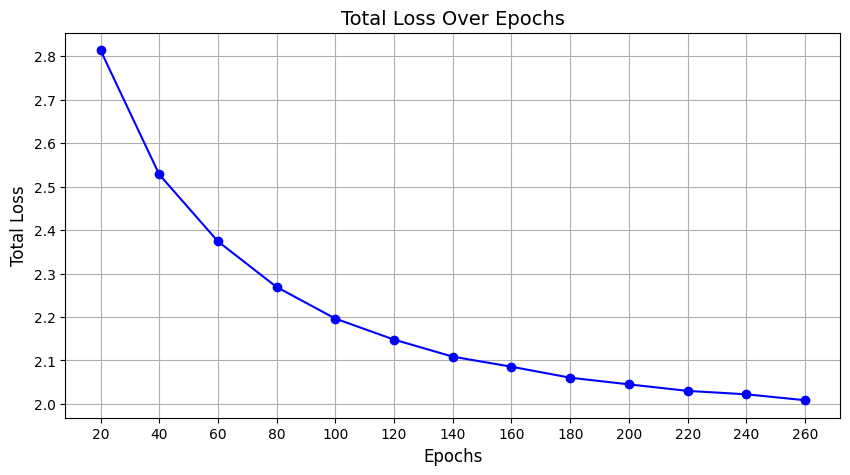

In [ ]:
# Import necessary libraries
import matplotlib.pyplot as plt

# Updated data for the new line graph
steps_new = [20, 40, 60, 80, 100, 120, 140, 160,180,200,220,240,260]
total_loss_new = [
    2.81377706, 2.52794697, 2.37385826, 2.26888668, 2.19622535,
    2.14789317, 2.10868187, 2.08551366, 2.06023689, 2.04491492,
    2.02988827, 2.02202595, 2.00842150,

]

# Create the updated plot
plt.figure(figsize=(10, 5))
plt.plot(steps_new, total_loss_new, marker='o', linestyle='-', color='blue')

# Add titles and labels
plt.title('Total Loss Over Epochs', fontsize=14)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Total Loss', fontsize=12)

# Set x-axis ticks to display every 500th step
plt.xticks(range(20, 280, 20), fontsize=10)

# Add grid for better readability
plt.grid(True)

# Display the plot
plt.show()